## SQL with Pandas

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3
%matplotlib inline
plt.style.use('ggplot')

Let's create a reader object, which will make it so that we can read the csv in chunks.  When we specify the chunksize this indicates that we want an iterator that will reach these chunks into memory.
You can get the data from [NYC open data](https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2) but be aware that it is over 2GB.

In [3]:
nycjobs_reader = pd.read_csv('data/DOB_Job_Application_Filings.csv',
                             chunksize=10000,low_memory=False,encoding='latin-1')

In [5]:
nycjobs_chunk = next(nycjobs_reader)
nyc_cols = nycjobs_chunk.columns

Let's create the sqlite file, and create the connection.

In [6]:
sqlite_file = 'data/nycjobs.sqlite'
nyc_conn = sqla.create_engine('sqlite:///' + sqlite_file)

The following code will create the table jobs and fill it in.

In [7]:
nycjobs_chunk.to_sql('jobs',nyc_conn,if_exists='replace')
for nycjobs_chunk in nycjobs_reader:
    nycjobs_chunk.to_sql('jobs',nyc_conn,if_exists='append')

Now, we get to make our first query.  Let's count the number of records in the jobs table.  We can also count the number of plumbing jobs.

In [8]:
pd.read_sql_query("select count(*) from jobs",nyc_conn)

,count(*)
0,5256484


In [9]:
pd.read_sql_query("select count(*) from jobs where Plumbing='X'",nyc_conn)

,count(*)
0,1717691


In [11]:
pd.read_sql_query("select Plumbing, count(*) as count from jobs group by Plumbing",nyc_conn)

,Plumbing,count
0,None,3492720
1,,46070
2,P,3
3,X,1717691


We can also order these by the initial cost in descending order.

In [12]:
sql_query = """
select * from jobs 
where Plumbing='X' 
order by "Initial Cost" desc
limit 5000
"""
plumbing = pd.read_sql_query(sql_query,nyc_conn)

In [12]:
plumbing.head()

,index,Job #,Doc #,Borough,House #,Street Name,Block,Lot,Bin #,Job Type,...,Owner's Last Name,Owner's Business Name,Owner's House Number,Owner'sHouse Street Name,City,State,Zip,Owner'sPhone #,Job Description,DOBRunDate
0,2800,320771198,1,BROOKLYN,68,GRAND STREET,2390,23,3062758,A1,...,DENNIS,N/A,68,GRAND STREET,BROOKLYN,NY,11249,7185992245,INTERIOR RENOVATION OF AN EXISTING 3 STORY PLU...,06/13/2013 12:00:00 AM
1,6346,220416841,1,BRONX,1160,CROMWELL AVENUE,2496,34,2003023,A2,...,FINKELSTEIN,1160 CROMWELL AVE LLC,111,BROOK STREET,SCARSTALE,NY,10585,9144724900,HEREWITH TO PROPOSE INTERIOR RENOVATION BATH R...,12/06/2014 12:00:00 AM
2,7727,321427595,2,BROOKLYN,441,COLUMBIA STREET,538,1,3334251,A2,...,MOORE,NEW YORK CITY HOUSING AUTHORITY,90,CHURCH STREET,NEW YORK,NY,10007,2123068563,REMOVE EXISTING HVAC EQUIPMENT AND PROVIDE NEW...,07/30/2016 12:00:00 AM
3,7519,122059084,1,MANHATTAN,160,WEST 66TH ST,1137,7501,1077844,A2,...,LO,None,160,WEST 66TH ST,NY,NY,10023,2154785182,RENOVATION AND COMBINATION OF APTS 22G AND 22H...,07/08/2014 12:00:00 AM
4,6898,321140975,1,BROOKLYN,100,MADISON STREET,1990,20,3057205,A2,...,GRIEVE,None,592,HANCOCK STREET,BROOKLYN,NY,11233,9176747891,"REPLACEMENT OF DAMAGED FLOOR JOISTS, FINISHES,...",07/02/2015 12:00:00 AM


In [20]:
plumbing['Initial Cost'] = plumbing['Initial Cost'].map(lambda x: int(x[1:-3]))

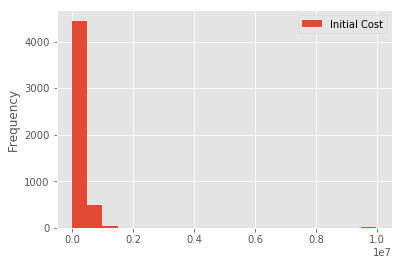

In [24]:
plumbing.plot(y = 'Initial Cost',kind='hist',bins=20)

Now, let's look at the "group by" clause, which will count the number of postings for each owner business name.

In [ ]:
query = """select "Owner's Business Name", count(*) as count from jobs 
    where "Owner's Business Name"!=" " 
    group by "Owner's Business Name" 
    limit 1000"""
owner_counts = pd.read_sql_query(query,nyc_conn)

In [23]:
owner_counts.head()

,Owner's Business Name,count
0,20 EAST 35 STREET OWNERS CORP,1
1,204 FORSYTH STREET LLC,1
2,30 WEST 76TH ST REALTY LLC,2
3,40 FLATBUSH REALTY ASSOCIATES,1
4,BRONXWOOD HOME FOR THE AGED IN,1


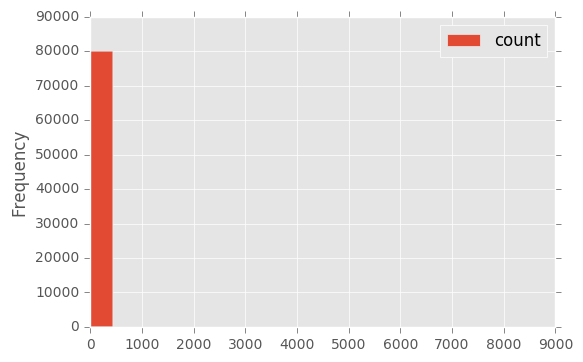

In [27]:
_ = owner_counts.plot.hist("count",bins=20)

Good thing we looked at this, there seem to be lots of outliers here, and so there are a few businesses with many postings.

In [45]:
(owner_counts['count'] > 1000).sum()

10

In [46]:
owner_counts[owner_counts['count'] > 1000]

,Owner's Business Name,count
58185,N/A,8682
58223,NA,1163
58994,NEW YORK CITY HOUSING AUTHORITY,1138
59515,NONE,1069
60359,NYC SCA,1003
60433,NYCHA,1336
61373,OWNER,1267
69643,SL GREEN REALTY CORP.,1227
70453,SPRING SCAFFOLDING LLC,1138
77249,VORNADO OFFICE MANAGEMENT,1303


So, we need to worry about the other encodings of NAs and the rest of these seem to be large organizations.

## sqlite3 package
Now, let's use the sqlite3 package to make more sql statements other than the select queries.  We will create a table of owners, and then make a join with the jobs table to demonstrate join.

In [37]:
conn3 = sqlite3.connect(sqlite_file)

In [38]:
c = conn3.cursor()

In [39]:
c.execute("""create table owner as
    select "Owner's Last Name", "Owner's First Name", 
    "Owner's Business Name", "Owner's House Number", "Owner'sPhone #",
    count(*) from jobs group by "Owner's Business Name" """)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 56))



OperationalError: table owner already exists

In [40]:
c.execute("""select *, count(*) from owner""")
c.fetchone()

(u'HAYDUK______',
 u'RICHARD',
 u'__STUYTOWN PROPERTY SERVICES__',
 u'__276',
 2124205000,
 1,
 80085)

In [43]:
c.execute("""select * from jobs left join owner 
    on "jobs.Owner's Business Name"="owner.Owner's Business Name" """)
c.fetchone()

(0,
 121577873,
 2,
 u'MANHATTAN',
 u'386         ',
 u'PARK AVENUE SOUTH               ',
 857,
 38,
 1016890,
 u'A2',
 u'D',
 u'APPLICATION PROCESSED - ENTIRE          ',
 u'04/25/2013',
 u'OTHER',
 u'105',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 u'Y',
 u'X',
 u'X',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u' ',
 u'               ',
 u'DOUGLAS        ',
 u'MASS                          ',
 u'PE',
 u'0058375',
 None,
 u'04/25/2013',
 u'04/25/2013',
 u'04/25/2013',
 None,
 None,
 None,
 u'$75000.00',
 u'$986.00',
 u'STANDARD',
 0,
 0,
 None,
 None,
 0,
 0,
 0,
 0,
 0,
 0,
 u'     ',
 u'     ',
 u'    ',
 u'    ',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 u'JAMES          ',
 u'MIGLIORE                      ',
 u'MACKLOWE MANAGEMENT             ',
 u'126         ',
 u'EAST 56TH STREET                ',
 u'NEW YORK       ',
 u'NY',
 10222,
 2125545837,
 u'GENERAL MECHANICAL & PLUMBING MODIFICATIONS AS PER PLANS FILED HEREWITH. NO      CHANG